In [17]:
import torch
import numpy as np
import pandas as pd
import codecs
import re
import nltk

from nltk.stem import WordNetLemmatizer

from collections import Counter

from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

from torch import tensor
from torch import nn
from torch import optim
from torch.autograd import Variable

# Parameters

In [2]:
# Number of recognized words you put in input
nb_input = 3

# Number of classe, constant
nb_output = 6

# Number of hidden layers
nb_hidd_lay = 3

### 0.Preprocessing

In [3]:
# Encoding in windows-1252, utf-8 generate error on some char
file = codecs.open("train_all.label", "r+","windows-1252")
train_data = []
list_of_words = []
for line in file.readlines():
    for word in line.split():
        list_of_words.append(word)
    train_data.append(line)

In [4]:
# Divided file into 2 list:
# questions = list of questions 
# labels = list of labels

questions = []
labels = []

(train_data[0]).split()[0]
for string in train_data:
    labels.append(string.split()[0])
    questions.append(string.split()[1:])
len(questions)

15452

In [5]:
# Lemmatisation
# Je travaille sur list_of_words
def lemm(phrase):
    lemmer = WordNetLemmatizer()
    lemmed = []
    for word in phrase:
        lemmed.append(lemmer.lemmatize(word, pos="v"))
    return lemmed

In [6]:
list_of_lemms = lemm(list_of_words)

In [24]:
# Method to add tags begin and end to phrases list.
# /!\ 
# WARNING : this method need to be executed only ONE time.
# /!\
def add_tag():
    for i in range(0, len(questions)):
        if questions[i][0] != '<bos>' :
            questions[i].insert(0, '<bos>')
            questions[i].append('<eos>')
add_tag()

In [26]:
# questions

In [27]:
# Using sklearn to get the vocabulary
vectorizer = CountVectorizer()
str_questions = []
for quest in questions:
    str_questions.append(' '.join(quest))
output = vectorizer.fit(str_questions)

In [28]:
# This is the vocabulary dict.
vocabulary = output.vocabulary_
word_list = list(vocabulary.keys())
words_array = np.array(word_list)

In [29]:
# Integer encoding with OneHotEncoder
words_tre = words_array.reshape(len(words_array),1)
one_hot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = one_hot_encoder.fit_transform(words_tre)
print(onehot_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
# Creating a dictionnary of word and it one hot array
words_onehoted = {}
for i in range(0, len(words_array)):
    words_onehoted[word_list[i]] = onehot_encoded[i]

In [31]:
# Function to get the one hot list for a choosed word.
def get_onehot_word(word):
    out = []
    for key, value in words_onehoted.items():
        if key == word:
            out = list(value)
    return out

In [33]:
# get_onehot_word('bos')

# RNN implementation
Using ReLU, and CrossEntropy

In [34]:
class RNN(nn.Module):
    def __init__(self, nb_inputs, nb_layers, nb_neurons, nb_outputs, learning_rate):
        super(RNN, self).__init__()
        
        # Applying RNN layer, and softmax then
        self.rnn = nn.RNN(input_size=nb_inputs, num_layers=nb_layers,
                   hidden_size=nb_neurons, dropout=0.5, batch_first=True, nonlinearity='relu')
        self.softmax = nn.Softmax(nb_outputs)
        
        # Other usefull variables here
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.input_dim = nb_inputs
        self.output_dim = nb_output
        self.nb_layers = nb_layers
        self.nb_neurons = nb_neurons
        
    def forward(self, inputs):
        h0 = Variable(torch.zeros(self.nb_layers, inputs.size(0), self.nb_neurons))
        x, hn = self.rnn(inputs, h0)
        return self.softmax(x)

# End of the class RNN

# Now let's define learn(), which learn a RNN some data
def learn(rnn, batch_list, num_epochs=1):
    
    # Preparing
    rnn.train()
    losses = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(batch_list):
            data, target = Variable(data), Variable(target)
            
            output = rnn(data)
            loss = criterion(output, target)
            
            losses.append(loss.data.item())

            rnn.optimizer.zero_grad()

            loss.backward()
            rnn.optimizer.step()
            
            # Print the progress
            if batch_idx % 100 == 0 or batch_idx % 100 == 1 or batch_idx == len(batch_list)-1:
                print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                        epoch, 
                        (batch_idx+1) * len(data), 
                        len(batch_list),
                        100. * (batch_idx+1) / len(batch_list), 
                        loss.data.item()), 
                        end='')
        print()
        
    # Return losses list, you can print them later if you want
    return losses

# Example - Let's try our RNN
Dans cet exemple, nous avons un dataset très basique. Nous avons 2 outputs. Si dans la séquence donnée, une entrée est égale à 1, alors on attendra que la première sortie soit activée. Autrement, nous nous attendrons à ce que la seconde sortie soit activée

In [37]:
# Basically, meet a 1 and activate the first output; the second one if only 0 have been encountered
batch_list = [
    [tensor([[ [0., 0.], [0., 0.] ]]), tensor([ [0, 1] ])],
    [tensor([[ [0., 0.], [0., 0.], [0., 0.] ]]), tensor([ [0, 1] ])],
    [tensor([[ [0., 0.], [0., 0.], [0., 0.], [0., 0.] ]]), tensor([ [0, 1] ])],
    [tensor([[ [0., 0.], [0., 0.], [0., 0.], [0., 0.], [0., 0.] ]]), tensor([ [0, 1] ])],
    [tensor([[ [1., 0.], [0., 0.], [0., 0.] ]]), tensor([ [1, 0] ])],
    [tensor([[ [0., 0.], [1., 1.], [0., 0.] ]]), tensor([ [1, 0] ])],
    [tensor([[ [0., 0.], [1., 0.], [1., 0.] ]]), tensor([ [1, 0] ])],
    [tensor([[ [1., 0.], [1., 0.], [1., 0.] ]]), tensor([ [1, 0] ])]
]

rnn = RNN(nb_inputs = 2, nb_layers=3, nb_neurons=2, nb_outputs=2, learning_rate=0.01)

losses = learn(rnn, batch_list, 100)

 Train Epoch: 0 [8/8 (100%)]	 Loss: 1.094793
 Train Epoch: 1 [8/8 (100%)]	 Loss: 1.086962
 Train Epoch: 2 [8/8 (100%)]	 Loss: 1.013190
 Train Epoch: 3 [8/8 (100%)]	 Loss: 1.088379
 Train Epoch: 4 [8/8 (100%)]	 Loss: 1.277158
 Train Epoch: 5 [8/8 (100%)]	 Loss: 1.079743
 Train Epoch: 6 [8/8 (100%)]	 Loss: 1.103290
 Train Epoch: 7 [8/8 (100%)]	 Loss: 1.025922
 Train Epoch: 8 [8/8 (100%)]	 Loss: 1.095466
 Train Epoch: 9 [8/8 (100%)]	 Loss: 1.177065
 Train Epoch: 10 [8/8 (100%)]	 Loss: 0.993962
 Train Epoch: 11 [8/8 (100%)]	 Loss: 0.955587
 Train Epoch: 12 [8/8 (100%)]	 Loss: 0.870994
 Train Epoch: 13 [8/8 (100%)]	 Loss: 0.860864
 Train Epoch: 14 [8/8 (100%)]	 Loss: 0.910905
 Train Epoch: 15 [8/8 (100%)]	 Loss: 1.106366
 Train Epoch: 16 [8/8 (100%)]	 Loss: 1.253751
 Train Epoch: 17 [8/8 (100%)]	 Loss: 1.243491
 Train Epoch: 18 [8/8 (100%)]	 Loss: 0.903118
 Train Epoch: 19 [8/8 (100%)]	 Loss: 1.176855
 Train Epoch: 20 [8/8 (100%)]	 Loss: 1.095363
 Train Epoch: 21 [8/8 (100%)]	 Loss: 0.94805

Maintenant, nous affichons notre courbe d'erreur

Elle semble la même au fil du temps ici, parce que l'on a vraiment très peu de données

(Code provenant du TP de Barrault)

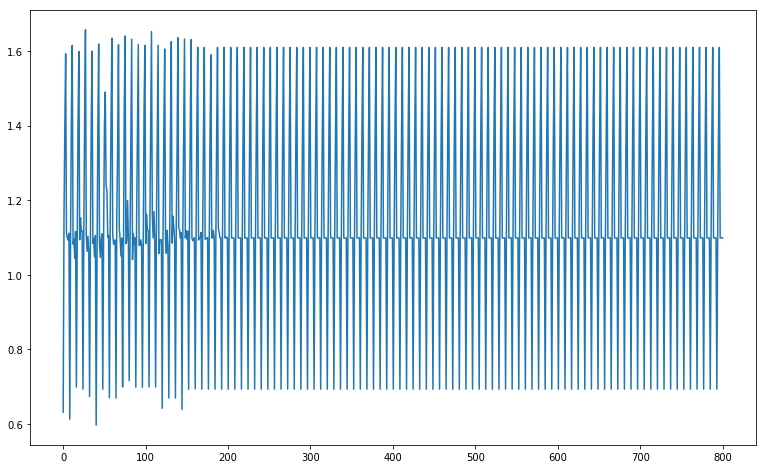

interactive(children=(IntSlider(value=51, description='smooth', max=201, min=5, step=2), Output()), _dom_class…

In [36]:
from scipy.signal import savgol_filter
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

x = np.linspace(0, len(losses), len(losses))
fig = plt.figure(figsize=(13, 8)) 
ax = fig.add_subplot(1,1,1)
cnn_line, = ax.plot(x, losses)

def update_losses(smooth=51):
    cnn_line.set_ydata(savgol_filter(losses, smooth, 3))
    fig.canvas.draw()

interact(update_losses, smooth=(5, 201, 2));
